### Advanced Nueral Machine Translation with Attention.

This notebook is based on the [Tensorflow Tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention#create_a_tfdata_dataset) tutorial. In this notebook we are going to learn how to train a seq2seq model for Spanish to English translations based on [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5). 

We are going to start with this notebook before diving into [transfomers](https://www.tensorflow.org/text/tutorials/transformer).

### Setup

In [ ]:
!pip install tensorflow_text

In [2]:
import numpy as np
import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

tf.__version__

'2.5.0'

We are going builds a few layers from scratch, use this variable if you want to switch between the custom and builtin implementations.

In [3]:
use_builtins = True

### Data.

We are going to use the data from  http://www.manythings.org/anki/ This data contains langauge pair translations in the format:

```
May I borrow this book? ¿Puedo tomar prestado este libro?
```

### Dataset Preparation
I've already downloaded the dataset and uploaded it on my google drive. For data preparation we are going to do the following:

1. Add a start and end token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

### Mounting my google drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
path_to_file = '/content/drive/My Drive/NLP Data/seq2seq/spa-en/spa.txt'
os.path.exists(path_to_file)

True

In [6]:
def load_data(path):
  lines = open(path, encoding='utf-8').read().split('\n')
  pairs = [line.split('\t') for line in lines]
  inp, targ = [], []
  for pair in pairs:
    if (len(pair) != 3):
      continue
    else:
      a, b, _ = pair
      inp.append(b)
      targ.append(a)
  return targ, inp

In [7]:
targ, inp = load_data(path_to_file)
print(len(inp), len(targ))
print(inp[0], targ[0])

134736 134736
Ve. Go.


### Creating teh dataset.
From this list of strings we are going to create a `tf.data.Dataset` of strings that shuffles and batches them efficiently.


In [9]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices((inp, 
                                              targ)).shuffle(
                                                  BUFFER_SIZE).batch(
                                                      BATCH_SIZE)

In [10]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'\xc2\xbfYa tienes algunas ideas?' b'A todos les agradan.'
 b'No me gusta mi trabajo.' b'Tr\xc3\xa1eme una silla, por favor.'
 b'No le har\xc3\xa9 da\xc3\xb1o.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Have you got any ideas yet?' b'Everyone likes them.'
 b"I don't like my job." b'Get me a chair, please.'
 b"I'm not going to hurt you."], shape=(5,), dtype=string)


### Text preprocessing.

In this notebook we are going to create a model that takes in string inputs and output string outputs not the model that takes strings and output logits.

### Standardization.
The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensroflow_text` package contains a unicode normalize operation:

In [11]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [12]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)
  text = tf.strings.join(['<sos>', text, '<eos>'], separator=' ')
  return text

In [13]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
<sos> ¿ todavia esta en casa ? <eos>


### Text Vectorization
This standardization function will be wrapped up in a `preprocessing.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

The `TextVectorization` layer and many other `experimental.preprocessing` layers have an adapt method. This method reads one epoch of the training data, and works a lot like `Model.fix`. This adapt method initializes the layer based on the data. 

In [15]:
max_vocab_size = 10_000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
    )
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
    )
input_text_processor.adapt(inp)
output_text_processor.adapt(targ)

The `preprocessing.TextVectorization` has a method called `get_vocabulary()` which list the number of uninque words in each source.

In [16]:
print(input_text_processor.get_vocabulary()[:5])
print(output_text_processor.get_vocabulary()[:5])

['', '[UNK]', '<sos>', '<eos>', '.']
['', '[UNK]', '<sos>', '<eos>', '.']


In [19]:
print("Vocab size spanish: ", len(input_text_processor.get_vocabulary()))
print("Vocab size english: ", output_text_processor.vocabulary_size())

Vocab size spanish:  10000
Vocab size english:  10000


Now these layers can convert a batch of strings into a batch of token IDs:

In [21]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   13,   81,   89,  367, 1407,   12,    3,    0,    0],
       [   2,    9,   64,  197, 7127,    4,    3,    0,    0,    0],
       [   2,    8,   18,   63,   24,   87,    4,    3,    0,    0]])>

### Getting the vocabulary.
WE can use the `get_vocabulary()` method to convert tokens IDS to back to text.

In [22]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'<sos> ¿ ya tienes algunas ideas ? <eos>                                             '

In [23]:
example_tokens[1]

<tf.Tensor: shape=(53,), dtype=int64, numpy=
array([   2,    9,   64,  197, 7127,    4,    3,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])>

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

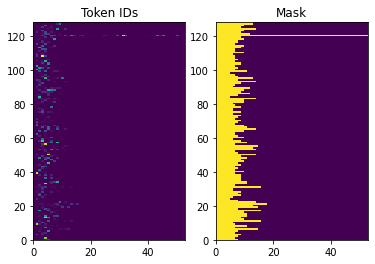

In [24]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

### The encoder/decoder model.
The following diagram shows an overview of the model. At each time-step the decoder's output is combined with a weighted sum over the encoded input, to predict the next word.

![img](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)

### Before getting into it let's define some constants.

In [25]:
embedding_dim = 256
units = 1024

### The `Enconder.`

We are going to start by building the ecoder the blue part of the diagram. The encoder:

1. Takes a list of tokens IDs (from `input_text_processor`)
2. Looks up an embbeding vector for each token using the keras `Layers.Embedding`
3. Processed the embeddings into a new sequence a `GRU` and then returns:
* The processed sequence. This will be passed to the attention head.
* The internal state. This will be used to initialize the decoder

In [27]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size,
               embedding_dim,
               enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)

    """ 3. 
    The GRU processes the embedding sequence.
    output shape: (batch, s, enc_units)
    state shape: (batch, enc_units)
    """
    output, state = self.gru(vectors, initial_state=state)
    # 4. Returns the new sequence and its state.
    return output, state


### Here is what we have so far?

In [28]:
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')


Input batch, shape (batch): (128,)
Input batch tokens, shape (batch, s): (128, 53)
Encoder output, shape (batch, s, units): (128, 53, 1024)
Encoder state, shape (batch, units): (128, 1024)


The encoder returns its internal state so that its state can be used to initialize the decoder.

It's also common for an RNN to return its state so that it can process a sequence over multiple calls. We will see more of that building the decoder.

### The attention head

The decoder uses attention to selectively focus on parts of the input sequence. The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a `layers.GlobalAveragePoling1D` but the attention layer performs a weighted average.

Let's have a look at how it works:

![img](https://www.tensorflow.org/text/tutorials/images/attention_equation_1.jpg)
![img](https://www.tensorflow.org/text/tutorials/images/attention_equation_2.jpg)

Where:
* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.

Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="https://github.com/tensorflow/text/blob/master/docs/tutorials/images/attention_equation_4.jpg?raw=1" alt="attention equation 4" width="800">

In this notebook we are going to use the [Bahdanau's additive attention](https://arxiv.org/pdf/1409.0473.pdf). TensorFlow includes implementations of both as `layers.Attention` and
`layers.AdditiveAttention`. The class below handles the weight matrices in a pair of `layers.Dense` layers, and calls the builtin implementation.


In [29]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask
    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    return context_vector, attention_weights

### Testing the Attention layer

In [30]:
attention_layer = BahdanauAttention(units)

This layer takes 3 inputs:

* The `query`: This will be generated by the decoder, later.
* The `value`: This Will be the output of the encoder.
* The `mask`: To exclude the padding, `example_tokens != 0`

In [31]:
(example_tokens != 0).shape

TensorShape([128, 53])

The vectorized implementation of the attention layer lets you pass a batch of sequences of query vectors and a batch of sequence of value vectors. The result is:

1. A batch of sequences of result vectors the size of the queries.
2. A batch attention maps, with size `(query_length, value_length)`.

In [32]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (128, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (128, 2, 53)


The attention weights should sum to `1.0` for each sequence.

Here are the attention weights across the sequences at `t=0`:

Text(0.5, 1.0, 'Mask')

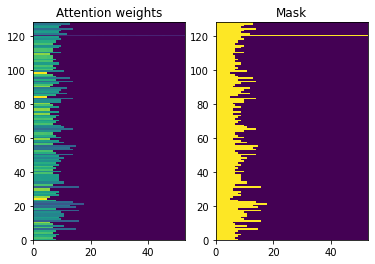

In [33]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [34]:
attention_weights.shape

TensorShape([128, 2, 53])

In [35]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

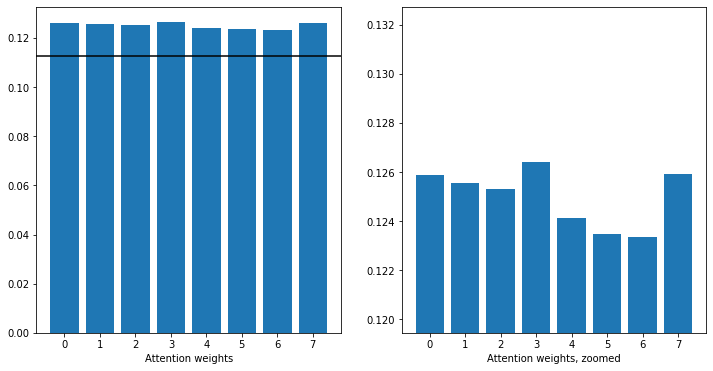

In [36]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

### The Decoder.

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
2. It uses an RNN to keep track of what it has generated so far.
3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4. It combines the RNN output and the context vector using Equation 3 (below) to generate the "attention vector".
5. It generates logit predictions for the next token based on the "attention vector".

<img src="https://github.com/tensorflow/text/blob/master/docs/tutorials/images/attention_equation_3.jpg?raw=1" alt="attention equation 3" width="800">

Here is the `Decoder` class and its initializer. The initializer creates all the necessary layers.




In [37]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [38]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

  def call(self,
         inputs: DecoderInput,
         state=None)  -> Tuple[DecoderOutput, tf.Tensor]:
    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)

    # Step 2. Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)

    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)

    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
    return DecoderOutput(logits, attention_weights), state


The **encoder** processes its full input sequence with a single call to its RNN. This implementation of the **decoder** _can_ do that as well for efficient training. But this notebook will run the decoder in a loop for a few reasons:

* Flexibility: Writing the loop gives you direct control over the training procedure.
* Clarity: It's possible to do masking tricks and use `layers.RNN`, or `tfa.seq2seq` APIs to pack this all into a single call. But writing it out as a loop may be clearer. 
  * Loop free training is demonstrated in the [Text generation](https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_generation.ipynb) tutiorial.


In [39]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

The decoder takes 4 inputs.

* `new_tokens` -  The last token generated. Initialize the decoder with the `"<sos>"` token.
* `enc_output` - Generated by the `Encoder`.
* `mask` - A boolean tensor indicating where `tokens != 0`
* `state` - The previous `state` output from the decoder (the internal state
  of the decoder's RNN). Pass `None` to zero-initialize it. The original
  paper initializes it from the encoder's final RNN state. 

In [41]:
# Convert the target sequence, and collect the "<sos>" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor._index_lookup_layer('<sos>').numpy()
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [42]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (128, 1, 10000)
state shape: (batch_size, dec_units) (128, 1024)


Sample a token according to the logits:

In [43]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

Decode the token as the first word of the output:

In [44]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['secure'],
       ['exhaled'],
       ['change'],
       ['make'],
       ['letter']], dtype='<U21')

Now use the decoder to generate a second set of logits.

- Pass the same `enc_output` and `mask`, these haven't changed.
- Pass the sampled token as `new_tokens`.
- Pass the `decoder_state` the decoder returned last time, so the RNN continues with a memory of where it left off last time.


In [45]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['savings'],
       ['fortyeight'],
       ['tangent'],
       ['ambidextrous'],
       ['mouse']], dtype='<U21')

### Training.
Now that we have all the model components, it's time to start training the model. We'll need:

- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.

### Loss function


In [46]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    
  def __call__(self, y_true, y_pred):
    loss = self.loss(y_true, y_pred)
    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask
    # Return the total.
    return tf.reduce_sum(loss)

### The train step

Start with a model class, the training process will be implemented as the `train_step` method on this model.

Here the `train_step` method is a wrapper around the `_train_step` implementation which will come later. This wrapper includes a switch to turn on and off `tf.function` compilation, to make debugging easier.

The `_train_step` method, handles the remaining steps except for actually running the decoder.

The `_loop_step` method executes the decoder and calculates the incremental loss and new decoder state (`dec_state`).

In [47]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)
  
  def _preprocess(self, input_text, target_text):
    # Convert the text to token IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    # Convert IDs to masks.
    input_mask = input_tokens != 0
    target_mask = target_tokens != 0
    return input_tokens, input_mask, target_tokens, target_mask

  def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,
    target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]
    with tf.GradientTape() as tape:
      # Encode the input
      enc_output, enc_state = self.encoder(input_tokens)
      """
      Initialize the decoder's state to the encoder's final state.
      This only works if the encoder and decoder have the same number of
      units.
      """
      dec_state = enc_state
      loss = tf.constant(0.0)

      for t in tf.range(max_target_length-1):
        """
        Pass in two tokens from the target sequence:
        1. The current input to the decoder.
        2. The target the target for the decoder's next prediction.
        """
        new_tokens = target_tokens[:, t:t+2]
        step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                              enc_output, dec_state)
        loss = loss + step_loss

      # Average the loss over all non padding tokens.
      average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

  def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                  enc_output=enc_output,
                                  mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)
    return step_loss, dec_state

  @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
  def _tf_train_step(self, inputs):
    return self._train_step(inputs)

    

Overall the implementation for the `Model.train_step` method is as follows:

1. Receive a batch of `input_text, target_text` from the `tf.data.Dataset`.
2. Convert those raw text inputs to token-embeddings and masks. 
3. Run the encoder on the `input_tokens` to get the `encoder_output` and `encoder_state`.
4. Initialize the decoder state and loss. 
5. Loop over the `target_tokens`:
   1. Run the decoder one step at a time.
   2. Calculate the loss for each step.
   3. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's `trainable_variables`.

### Test the training step

Build a `TrainTranslator`, and configure it for training using the `Model.compile` method:

In [48]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)
np.log(output_text_processor.vocabulary_size())

9.210340371976184

In [49]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.25198>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.230879>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.19039>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.070174>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5970163>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.3775034>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.6553535>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.466238>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3521514>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.314101>}

CPU times: user 19.1 s, sys: 4.08 s, total: 23.2 s
Wall time: 1min 14s


While it's easier to debug without a `tf.function` it does give a performance boost. So now that the `_train_step` method is working, try the `tf.function`-wrapped `_tf_train_step`, to maximize performance while training, SO THAT'S THE REASON WE ADDED THE `_tf_train_step`.

....................................................................................................


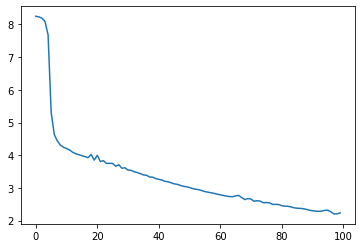

In [50]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=True)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

Now that we're confident that the training step is working, build a fresh copy of the model to train from scratch:

In [51]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Train the model

While there's nothing wrong with writing our own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code. 

This notebook only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [52]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [53]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
1053/1053 [==============================] - 749s 705ms/step - batch_loss: 3.3816
Epoch 2/3
1053/1053 [==============================] - 736s 699ms/step - batch_loss: 1.5418
Epoch 3/3
1053/1053 [==============================] - 734s 696ms/step - batch_loss: 0.9238


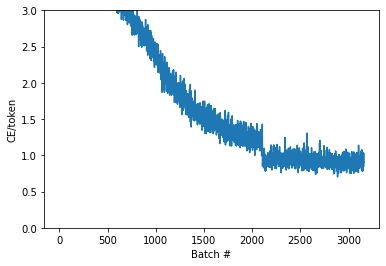

In [56]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')
plt.show()

## Translate

Now that the model is trained let's implement a function to execute the full `text => text` translation.

For this the model needs to invert the `text => token IDs` mapping provided by the `output_text_processor`. It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

### Implementing the translation loop.

Here is a complete implementation of the text to text translation loop.

This implementation collects the results into python lists, before using `tf.concat` to join them into tensors.

This implementation statically unrolls the graph out to `max_length` iterations.
This is okay with eager execution in python.

If you want to export this model you'll need to wrap this method in a `tf.function`. This basic implementation has a few issues if you try to do that:

1. The resulting graphs are very large and take a few seconds to build, save or load.
2. You can't break from a statically unrolled loop, so it will always run `max_length` iterations, even if all the outputs are done. But even then it's marginally faster than eager execution.




In [57]:
class Translator(tf.Module):
  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '<sos>']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string('<sos>')
    self.end_token = index_from_string('<eos>')

  def tokens_to_text(self, result_tokens):
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    result_text = tf.strings.reduce_join(result_text_tokens,
                                        axis=1, separator=' ')
    result_text = tf.strings.strip(result_text)
    return result_text

  def sample(self, logits, temperature):
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)
    if temperature == 0.0:
      new_tokens = tf.argmax(logits, axis=-1)
    else: 
      logits = tf.squeeze(logits, axis=1)
      new_tokens = tf.random.categorical(logits/temperature,
                                          num_samples=1)
    return new_tokens

  def translate(self,
                  input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
      dec_input = DecoderInput(new_tokens=new_tokens,
                              enc_output=enc_output,
                              mask=(input_tokens!=0))
      
      dec_result, dec_state = self.decoder(dec_input, state=dec_state)

      attention.append(dec_result.attention_weights)

      new_tokens = self.sample(dec_result.logits, temperature)

      # If a sequence produces an `end_token`, set it `done`
      done = done | (new_tokens == self.end_token)
      # Once a sequence is done it only produces 0-padding.
      new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

      # Collect the generated tokens
      result_tokens.append(new_tokens)

      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
      attention_stack = tf.concat(attention, axis=1)
      return {'text': result_text, 'attention': attention_stack}
    else:
      return {'text': result_text}

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def tf_translate(self, input_text):
    return self.translate(input_text)


### Translator instance.

In [58]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [59]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

very cold here .
this is my life .

CPU times: user 84.6 ms, sys: 5.16 ms, total: 89.7 ms
Wall time: 95.8 ms


Run the `tf.function` once to compile it


In [60]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 21 s, sys: 457 ms, total: 21.5 s
Wall time: 21.4 s


In [61]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

it is too cold .
this is my life .

CPU times: user 219 ms, sys: 24.6 ms, total: 244 ms
Wall time: 333 ms


### User input.

In [65]:
inp[500:505], targ[500:505], 

(['Tom se fue.', 'Tom mintió.', 'Tom mentía.', 'Tomás miente.', 'Tom perdió.'],
 ['Tom left.', 'Tom lied.', 'Tom lied.', 'Tom lies.', 'Tom lost.'])

In [66]:
while True:
  text = input("Enter a spanish sentence:\n")
  text_cleaned = tf_lower_and_split_punct(text).numpy().decode()
  input_text = tf.constant([text_cleaned])
  print()
  result = translator.translate(input_text)
  result = result['text'][0].numpy().decode()
  print(f"Spanish: > {text}")
  print(f"English: < {result}")
  print()

Enter a spanish sentence:
Tom se fue.

Spanish: > Tom se fue.
English: < youre gone .

Enter a spanish sentence:
Tom mintió.

Spanish: > Tom mintió.
English: < youre totally picky .

Enter a spanish sentence:
Tom mentía.

Spanish: > Tom mentía.
English: < youre innocent .

Enter a spanish sentence:
Tomás miente.

Spanish: > Tomás miente.
English: < youre agent .

Enter a spanish sentence:
Tom perdió

Spanish: > Tom perdió
English: < youre an ordinary nurse .



KeyboardInterrupt: ignored

### Visualize the process.
The attention weights returned by the `translate` method show where the model was "looking" when it generated each output token.

So the sum of the attention over the input should return all ones:

In [69]:
result = translator.tf_translate(
    input_text = input_text)
a = result['attention'][0]

print(np.sum(a, axis=-1))

[1.0000001  1.         1.         1.         1.0000001  1.
 1.         1.         0.99999994 1.         0.99999994 1.
 1.         0.99999994 1.         0.99999994 0.99999994 1.
 1.         1.         1.0000001  1.         1.         1.
 1.         1.         1.         1.0000001  0.99999994 1.0000001
 1.         1.         0.99999994 1.         1.         1.
 1.0000001  1.         1.         1.         1.         1.
 0.99999994 1.0000001  0.9999999  1.         0.99999994 0.9999999
 1.0000001  1.        ]


Here is the attention distribution for the first output step of the first example. Note how the attention is now much more focused than it was for the untrained model:

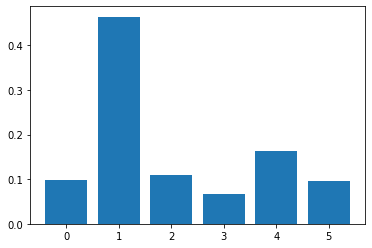

In [70]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

Since there is some rough alignment between the input and output words, you expect the attention to be focused near the diagonal:

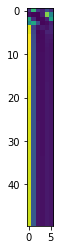

In [71]:
plt.imshow(np.array(a), vmin=0.0)

Here is some code to make a better attention plot:

In [72]:
#@title Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['<eos>']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

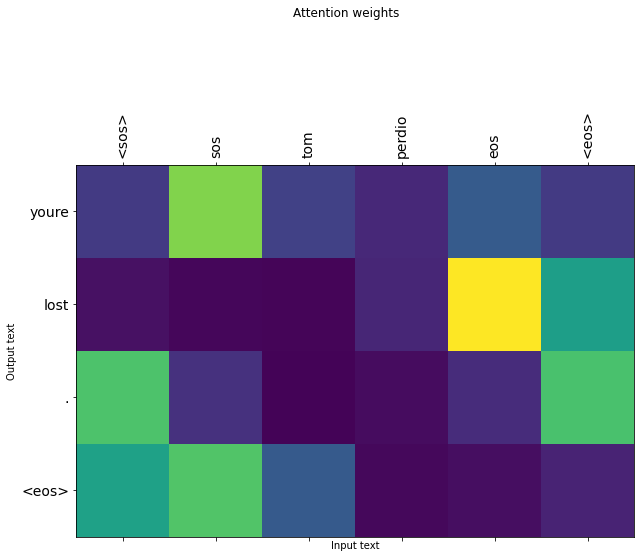

In [73]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

Translate a few more sentences and plot them:

In [74]:
%%time
three_input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

this is my life .
are still not home ?
try to solve it .

CPU times: user 213 ms, sys: 33.1 ms, total: 246 ms
Wall time: 332 ms


In [75]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'this is my life .', b'are still not home ?',
       b'try to solve it .'], dtype=object)>

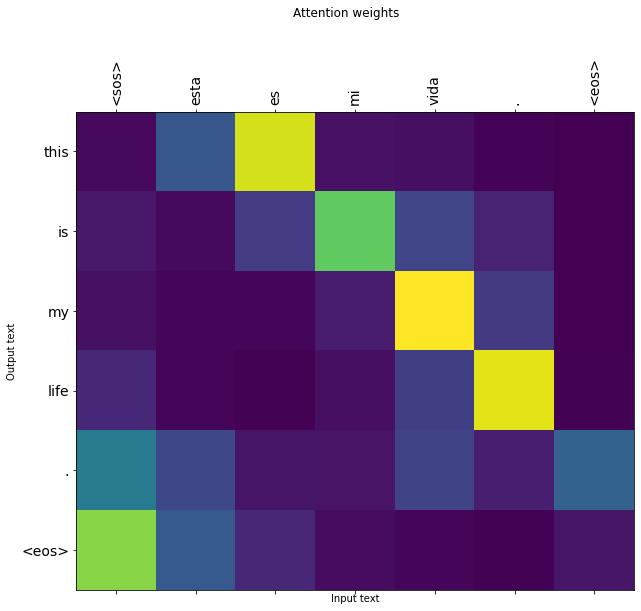

In [76]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

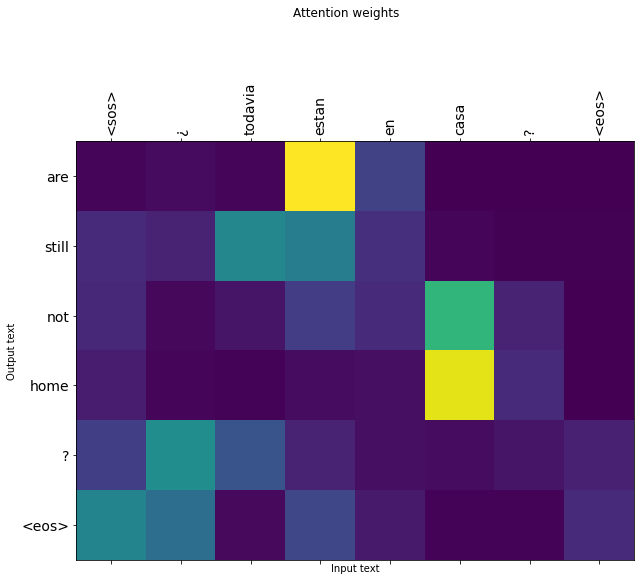

In [77]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

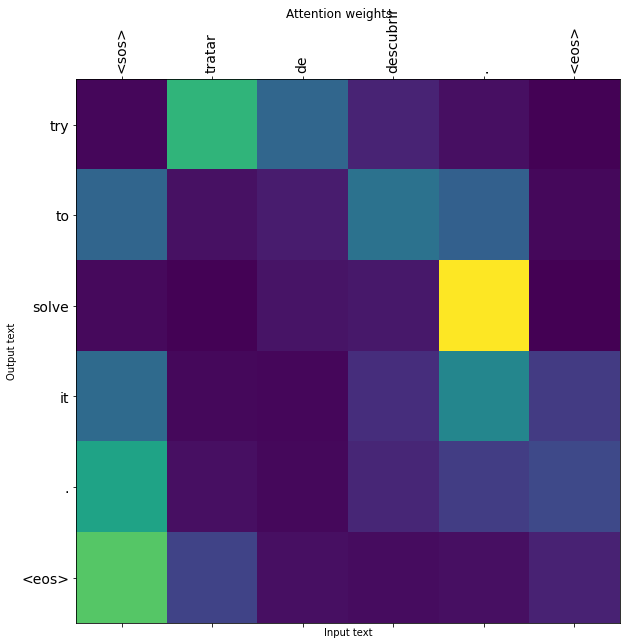

In [78]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state gets corrupted, there's no way for the model to recover. [Transformers](https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb) solve this by using self-attention in the encoder and decoder.

In [79]:
long_input_text = tf.constant([inp[-1]])

In [80]:

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))


Expected output:
 One day, I woke up to find that God had put hair on my face. I shaved
it off. The next day, I found that God had put it back on my face, so
I shaved it off again. On the third day, when I found that God had put
hair back on my face again, I decided to let God have his way. That's
why I have a beard.


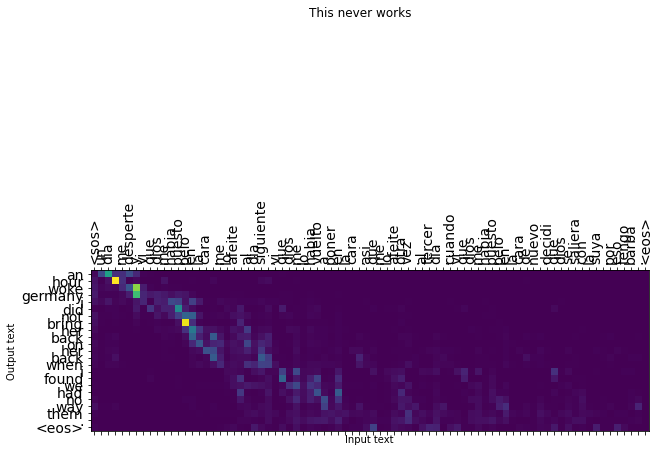

In [87]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

### Conclusion

If you want to deep dive more [this is the notebook](https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb#scrollTo=RTe5P5ioMJwN).

What you can try after this?

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb) which implements a similar translation task but uses a transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement wordpiece tokenization.
* Have a look at the [tensorflow_addons.seq2seq](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt) for implementing this sort of sequence to sequence model. The `tfa.seq2seq` package includes higher level functionality like `seq2seq.BeamSearchDecoder`. 